In [45]:
import nltk
import re
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [50]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (8, 4) # Size of plot
rcParams['figure.dpi'] = 100 #Dots per inch of plot
rcParams['lines.linewidth'] = 2 # Width of lines of the plot
rcParams['axes.facecolor'] = 'white' #Color of the axes
rcParams['font.size'] = 12 # Size of the text.
rcParams['patch.edgecolor'] = 'white' #Patch edge color.
rcParams['font.family'] = 'StixGeneral' #Font of the plot text.

### Lectura de Datos

In [87]:
#Carga todos los csv de las noticias.
path = os.getcwd()
csv_files =[]
for file in os.listdir(path):
    if file.endswith(".csv") and 'diario_libre_fb' not in file:
         csv_files.append(os.path.join(path, file))


In [88]:
diarios = ['Diario Libre','El Dia','Hoy','Listin Diario','El Nacional']

In [13]:
#Unirlos todos en un solo Dataframe.
noticias_df_all = None
for i,periodico in enumerate(csv_files):
    
    noticias_df = pd.read_csv(csv_files[0],encoding = 'latin1').iloc[:,1:]
    noticias_df['Diario'] = diarios[i]
    if noticias_df_all is None:
        noticias_df_all = noticias_df
    else:
        noticias_df_all = noticias_df_all.append(noticias_df)

noticias_df_all.reset_index(drop = True,inplace = True)
noticias_df_all.describe()

,contenidos,fechas,titulos,url,Diario
count,7685,10075,11285,11585,11585
unique,1470,1201,2133,2269,5
top,"LOJA, Ecuador. Tiene unos 10 años, mide alred...",2013-06-01 12:00:00,Periódico líder de la República Dominicana,http://www.diariolibre.com/fotos/,Diario Libre
freq,155,125,150,90,2317


In [14]:
noticias_df_completas = noticias_df_all.loc[pd.notnull(noticias_df_all.contenidos)]
noticias_df_completas.shape

(7685, 5)

### Limpieza de Texto

#### Stopwords: Palabras cuya presencia no cambia el valor análitico de los valores de una oración.

In [22]:
spanish_stops = set(nltk.corpus.stopwords.words('Spanish'))
list(spanish_stops)[:10]

['seríais',
 'sus',
 'hubieran',
 'estaba',
 'serán',
 'hube',
 'fueras',
 'durante',
 'teníamos',
 'hubierais']

In [89]:
import unicodedata
pd.options.mode.chained_assignment = None 
def strip_accents(s):
    #Reemplaza las letras con tilde por su equivalente sin tilde.
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [27]:
def Clean_Text(text):
    #Limpia strings.
    
    words = letters_only.lower().split() #LLeva todo a minuscula y divide en palabras.
    removed_stops = [w for w in words if not w  in spanish_stops and len(w)!=1] # ELimina stopwords y palabras de una sola letra.
    no_accents = strip_accents(text) #Reemplaza tildes.
    letters_only = re.sub("[^a-zA-Z]"," ", no_accents) #Elimina caracteres no alfabeticos.
    
    
    return " ".join(removed_stops)#Unirlo todo a una oración nuevamente.

noticias_df_completas['contenido limpio'] = noticias_df_completas.contenidos.apply(Clean_Text)
noticias_df_completas[['contenidos','contenido limpio']].head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,contenidos,contenido limpio
0,SANTO DOMINGO. Falleció la mañana de este sába...,santo domingo fallecio manana sabado paracaidi...
1,SANTO DOMINGO. El destacado abogado Domingo Po...,santo domingo destacado abogado domingo porfir...
2,TAIWÁN. El gobierno y el pueblo taiwanés están...,taiwan gobierno pueblo taiwanes estan atentos ...
4,SANTO DOMINGO. Una delegación comercial de Tur...,santo domingo delegacion comercial turquia enc...
5,SANTIAGO. El Ayuntamiento de Santiago colocó u...,santiago ayuntamiento santiago coloco valla pu...


#### Stemming: Llevar una palabra a su raíz.

In [31]:
from nltk.stem.snowball import SnowballStemmer
spanish_stemmer = SnowballStemmer("spanish")
print(spanish_stemmer.stem("corriendo"))
print(spanish_stemmer.stem("correr"))

corr
corr


In [32]:
def stem_text(text):
    stemmed_text = [spanish_stemmer.stem(word) for word in text.split()]
    return " ".join(stemmed_text)

noticias_df_completas['contenido stemmed'] = noticias_df_completas['contenido limpio'].apply(stem_text)
noticias_df_completas.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,contenidos,fechas,titulos,url,Diario,contenido limpio,contenido stemmed
0,SANTO DOMINGO. Falleció la mañana de este sába...,2017-10-07 11:05:00,Fallece paracaidista dominicano tras accidente...,https://buff.ly/2fTOrZK,Diario Libre,santo domingo fallecio manana sabado paracaidi...,sant doming falleci manan sab paracaid luis lu...
1,SANTO DOMINGO. El destacado abogado Domingo Po...,2017-10-07 11:31:00,Falleció en la madrugada jurista Domingo Porfi...,https://buff.ly/2y2J8zu,Diario Libre,santo domingo destacado abogado domingo porfir...,sant doming destac abog doming porfiri roj nin...
2,TAIWÁN. El gobierno y el pueblo taiwanés están...,2017-10-07 12:00:00,Taiwán observa los contactos de China Popular ...,http://ht.ly/jpuA30fIal5,Diario Libre,taiwan gobierno pueblo taiwanes estan atentos ...,taiw gobiern puebl taiwan estan atent acerc ul...
4,SANTO DOMINGO. Una delegación comercial de Tur...,2017-10-07 12:00:00,"Turquía, tras mercado de acero República Domin...",http://ht.ly/LAoE30fIaQd,Diario Libre,santo domingo delegacion comercial turquia enc...,sant doming delegacion comercial turqui encuen...
5,SANTIAGO. El Ayuntamiento de Santiago colocó u...,2017-10-07 09:49:00,Ayuntamiento de Santiago colocará los nombres ...,http://ht.ly/H0sl30fIbpU,Diario Libre,santiago ayuntamiento santiago coloco valla pu...,santiag ayunt santiag coloc vall publicitari i...


## Análisis de Texto

#### Cuenta de Palabras

In [34]:
def Create_Combinations(all_text,number=1):
    """
    Dado un corpus de texto, retorna un count de las combinaciones de palabras únicas del mismo. No importa el orden de las 
    palabras, mientras esten en un mismo documento, o en este caso, noticia.
    parameters:
        -all_text- Pandas Series o Lista: Listado de todos los documentos.
        -number- int: Cantidad de palabras en una combinación. En el caso de 1, es un word count regular. En el caso de 2 o  más,
        se cuentan las combinaciones de n palabras en un documento.
    output:
        - df- Pandas DataFrame: Dataframe con las combinaciones de palabras y el número de veces que aparecen.
        
    """
    result = {}
    for text in all_text:
        #Itera por cada documento o noticia.
        for comb in list(itertools.combinations(text.split(), number)): #Crea todas las combinaciones de palabras en un documento.
            found = False
            temp_dict = {} 
            i =0
            while not found and i < len(comb):
                #Para asegurar de que no sea una misma palabra repetida dos o más veces.
                if comb[i] not in temp_dict:
                    temp_dict[comb[i]] = "Found"
                else:
                    found = True
                i += 1
            if not found:
                #Si está en el diccionario de resultados sumale 1, sino agregalo.
                if comb not in result:
                    result[comb]= 1
                else:
                    result[comb]+=1
    df = pd.DataFrame({ str(number) + "-Combinations": list(result.keys()),"Count":list(result.values())})
    return df.sort_values(by="Count",ascending=False)

one_ngrams = Create_ngrams(noticias_df_completas['contenido limpio'])
one_ngrams.head()

,1-Combinations,Count
212,"(mas,)",11145
1,"(domingo,)",6690
399,"(anos,)",5755
0,"(santo,)",5695
198,"(pais,)",5380


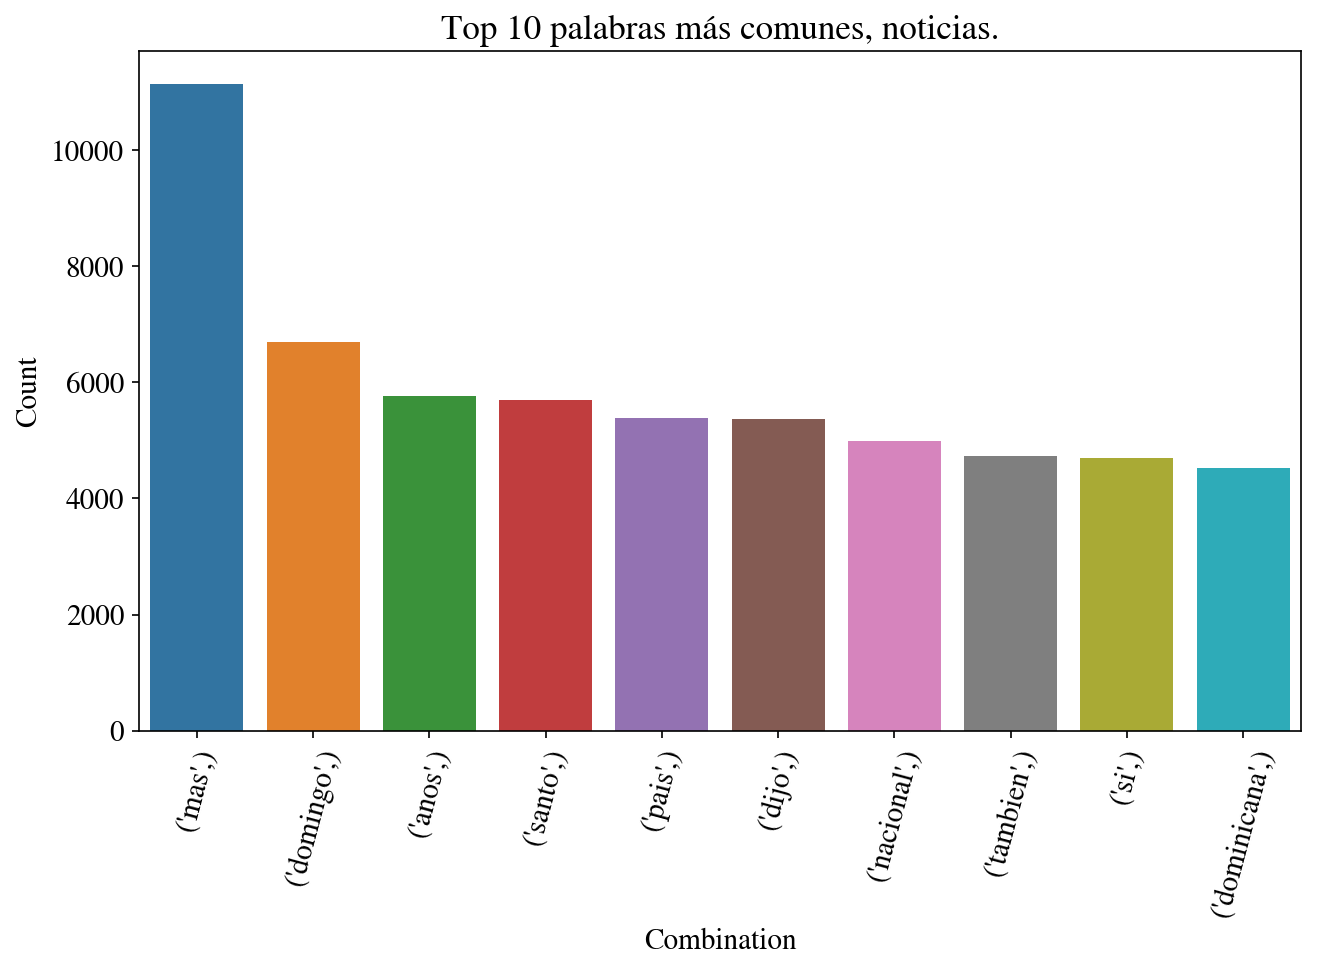

In [35]:
def Plot_nCombination(comb_df,n,title):
    #Crea un barplot con el count de palabras.
    sns.barplot(x=str(n) + "-Combinations",y = "Count",data = comb_df.head(10))
    plt.title(title)
    plt.xlabel("Combination")
    plt.ylabel("Count")
    plt.xticks(rotation = "75")
    plt.show()
    
Plot_nCombination(one_ngrams,1,"Top 10 palabras más comunes, noticias.")

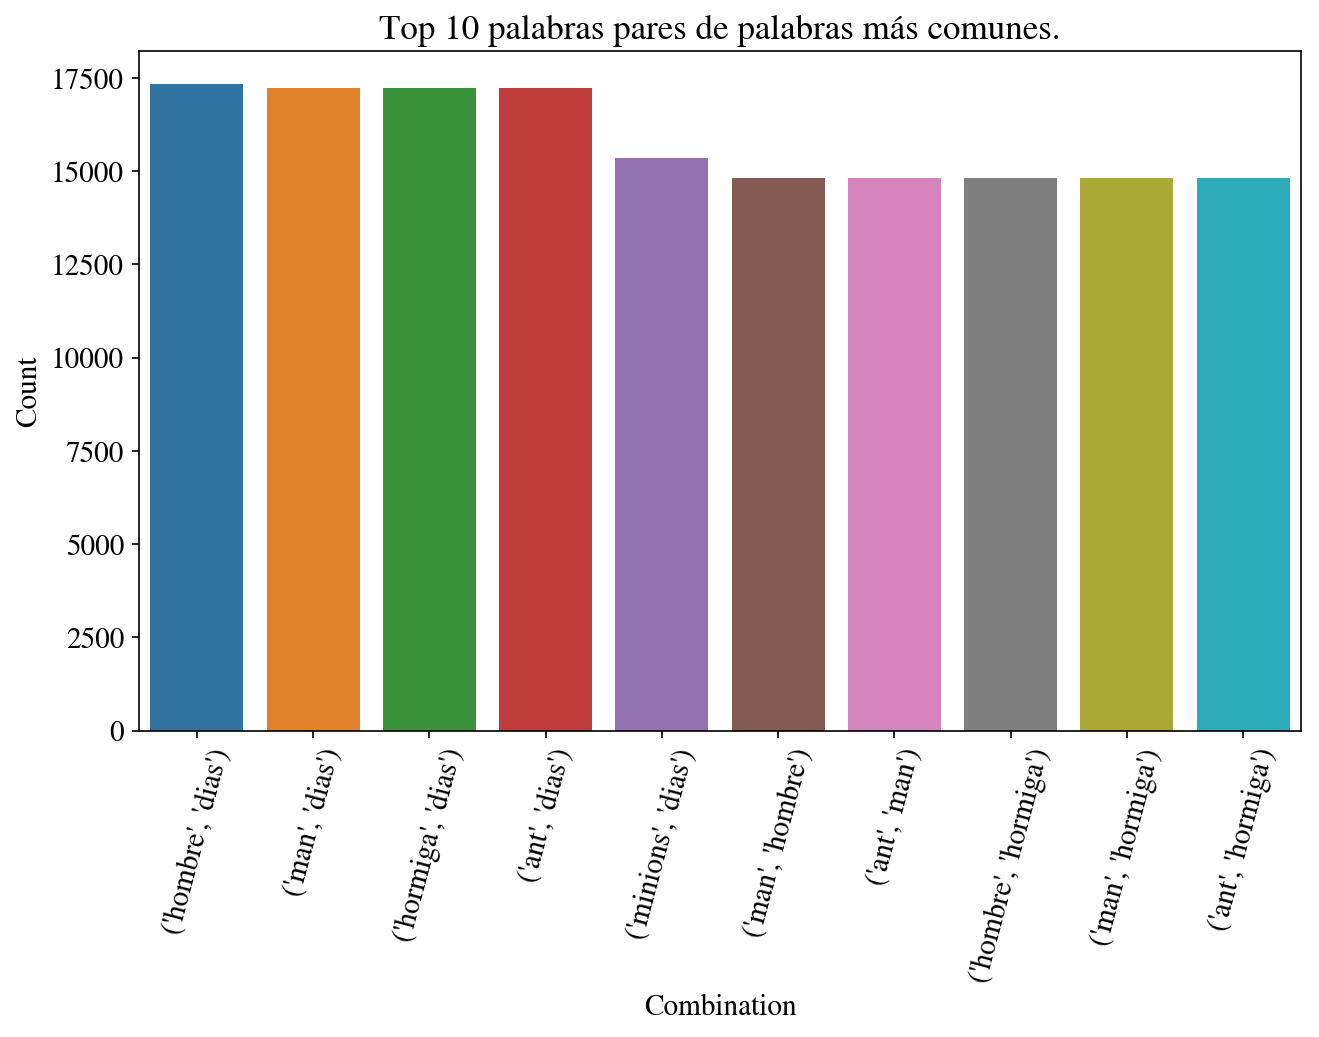

In [36]:
two_ngrams = Create_ngrams(noticias_df_completas['contenido limpio'],2)
Plot_nCombination(two_ngrams,2,"Top 10  pares de palabras más comunes.")

### TF-IDF

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
def Calculate_tfidf(text):
    #Calcula las puntuaciones de importancia de texto por medio de TF-IDF
    corpus = text
    vectorizer = TfidfVectorizer( min_df = 0.025, max_df = 0.25) #Cambia los parametros para limitar las palabras utilizadas.
    vector_weights = vectorizer.fit_transform(corpus) #Consigue la matriz de TF-IDF por documento, por palabra.
    weights= list(np.asarray(vector_weights.mean(axis=0)).ravel()) #Convierte la matriz en un solo arreglo por palabra.
    df = pd.DataFrame({"Word":vectorizer.get_feature_names(),"Score":weights}) #Crea un DataFrame con las palabras y su score.
    df = df.sort_values(by = "Score" ,ascending = False)
    return df,vector_weights.toarray()

Text_TfIdf,Text_Vector = Calculate_tfidf(noticias_df_completas['contenido limpio'])
Text_TfIdf.head(5)

,Score,Word
612,0.023864,millones
869,0.021457,republica
729,0.020991,personas
412,0.020055,gobierno
842,0.019970,rd


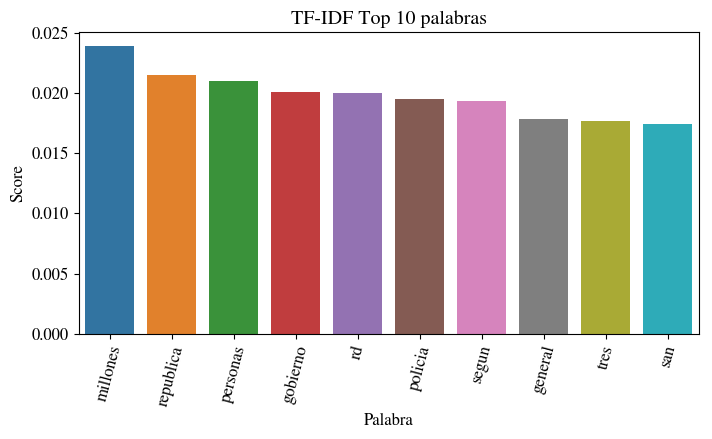

In [52]:
def Plot_Score(data,title):
    #Crea un barplot con los score de TF-IDF de las palabras.
    sns.barplot(x="Word",y = "Score",data = data.head(10))
    plt.title(title)
    plt.xlabel("Palabra")
    plt.ylabel("Score")
    plt.xticks(rotation = "75")
    plt.show()

Plot_Score(Text_TfIdf,"TF-IDF Top 10 palabras")

#### Word Clouds

En este caso, visualizar word clouds de noticias por fecha.

In [63]:
noticias_df_completas = noticias_df_completas.loc[pd.notnull(noticias_df_completas.fechas)]
noticias_df_completas.fechas = pd.to_datetime(noticias_df_completas.fechas)
noticias_df_completas['Mes'] = noticias_df_completas.fechas.dt.month
noticias_df_completas['Año'] = noticias_df_completas.fechas.dt.year
noticias_df_completas.head()

,contenidos,fechas,titulos,url,Diario,contenido limpio,contenido stemmed,Mes,Año
0,SANTO DOMINGO. Falleció la mañana de este sába...,2017-10-07 11:05:00,Fallece paracaidista dominicano tras accidente...,https://buff.ly/2fTOrZK,Diario Libre,santo domingo fallecio manana sabado paracaidi...,sant doming falleci manan sab paracaid luis lu...,10,2017
1,SANTO DOMINGO. El destacado abogado Domingo Po...,2017-10-07 11:31:00,Falleció en la madrugada jurista Domingo Porfi...,https://buff.ly/2y2J8zu,Diario Libre,santo domingo destacado abogado domingo porfir...,sant doming destac abog doming porfiri roj nin...,10,2017
2,TAIWÁN. El gobierno y el pueblo taiwanés están...,2017-10-07 12:00:00,Taiwán observa los contactos de China Popular ...,http://ht.ly/jpuA30fIal5,Diario Libre,taiwan gobierno pueblo taiwanes estan atentos ...,taiw gobiern puebl taiwan estan atent acerc ul...,10,2017
4,SANTO DOMINGO. Una delegación comercial de Tur...,2017-10-07 12:00:00,"Turquía, tras mercado de acero República Domin...",http://ht.ly/LAoE30fIaQd,Diario Libre,santo domingo delegacion comercial turquia enc...,sant doming delegacion comercial turqui encuen...,10,2017
5,SANTIAGO. El Ayuntamiento de Santiago colocó u...,2017-10-07 09:49:00,Ayuntamiento de Santiago colocará los nombres ...,http://ht.ly/H0sl30fIbpU,Diario Libre,santiago ayuntamiento santiago coloco valla pu...,santiag ayunt santiag coloc vall publicitari i...,10,2017


In [82]:
from wordcloud import WordCloud #Libreria para graficar word clouds.
rcParams['figure.dpi'] = 600
def crear_wordcloud_mes_anio(data,mes,anio):
    data = data.loc[(data.Mes == mes) & (data.Año == anio)]
    print("Existen {} articulos en los datos para el mes {} del año {}.".format(data.shape[0],mes,anio))
    wordcloud = WordCloud(
                          background_color='white',
                          max_words=200, 
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(data['contenido limpio']))
    
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Existen 45 articulos en los datos para el mes 9 del año 2016.


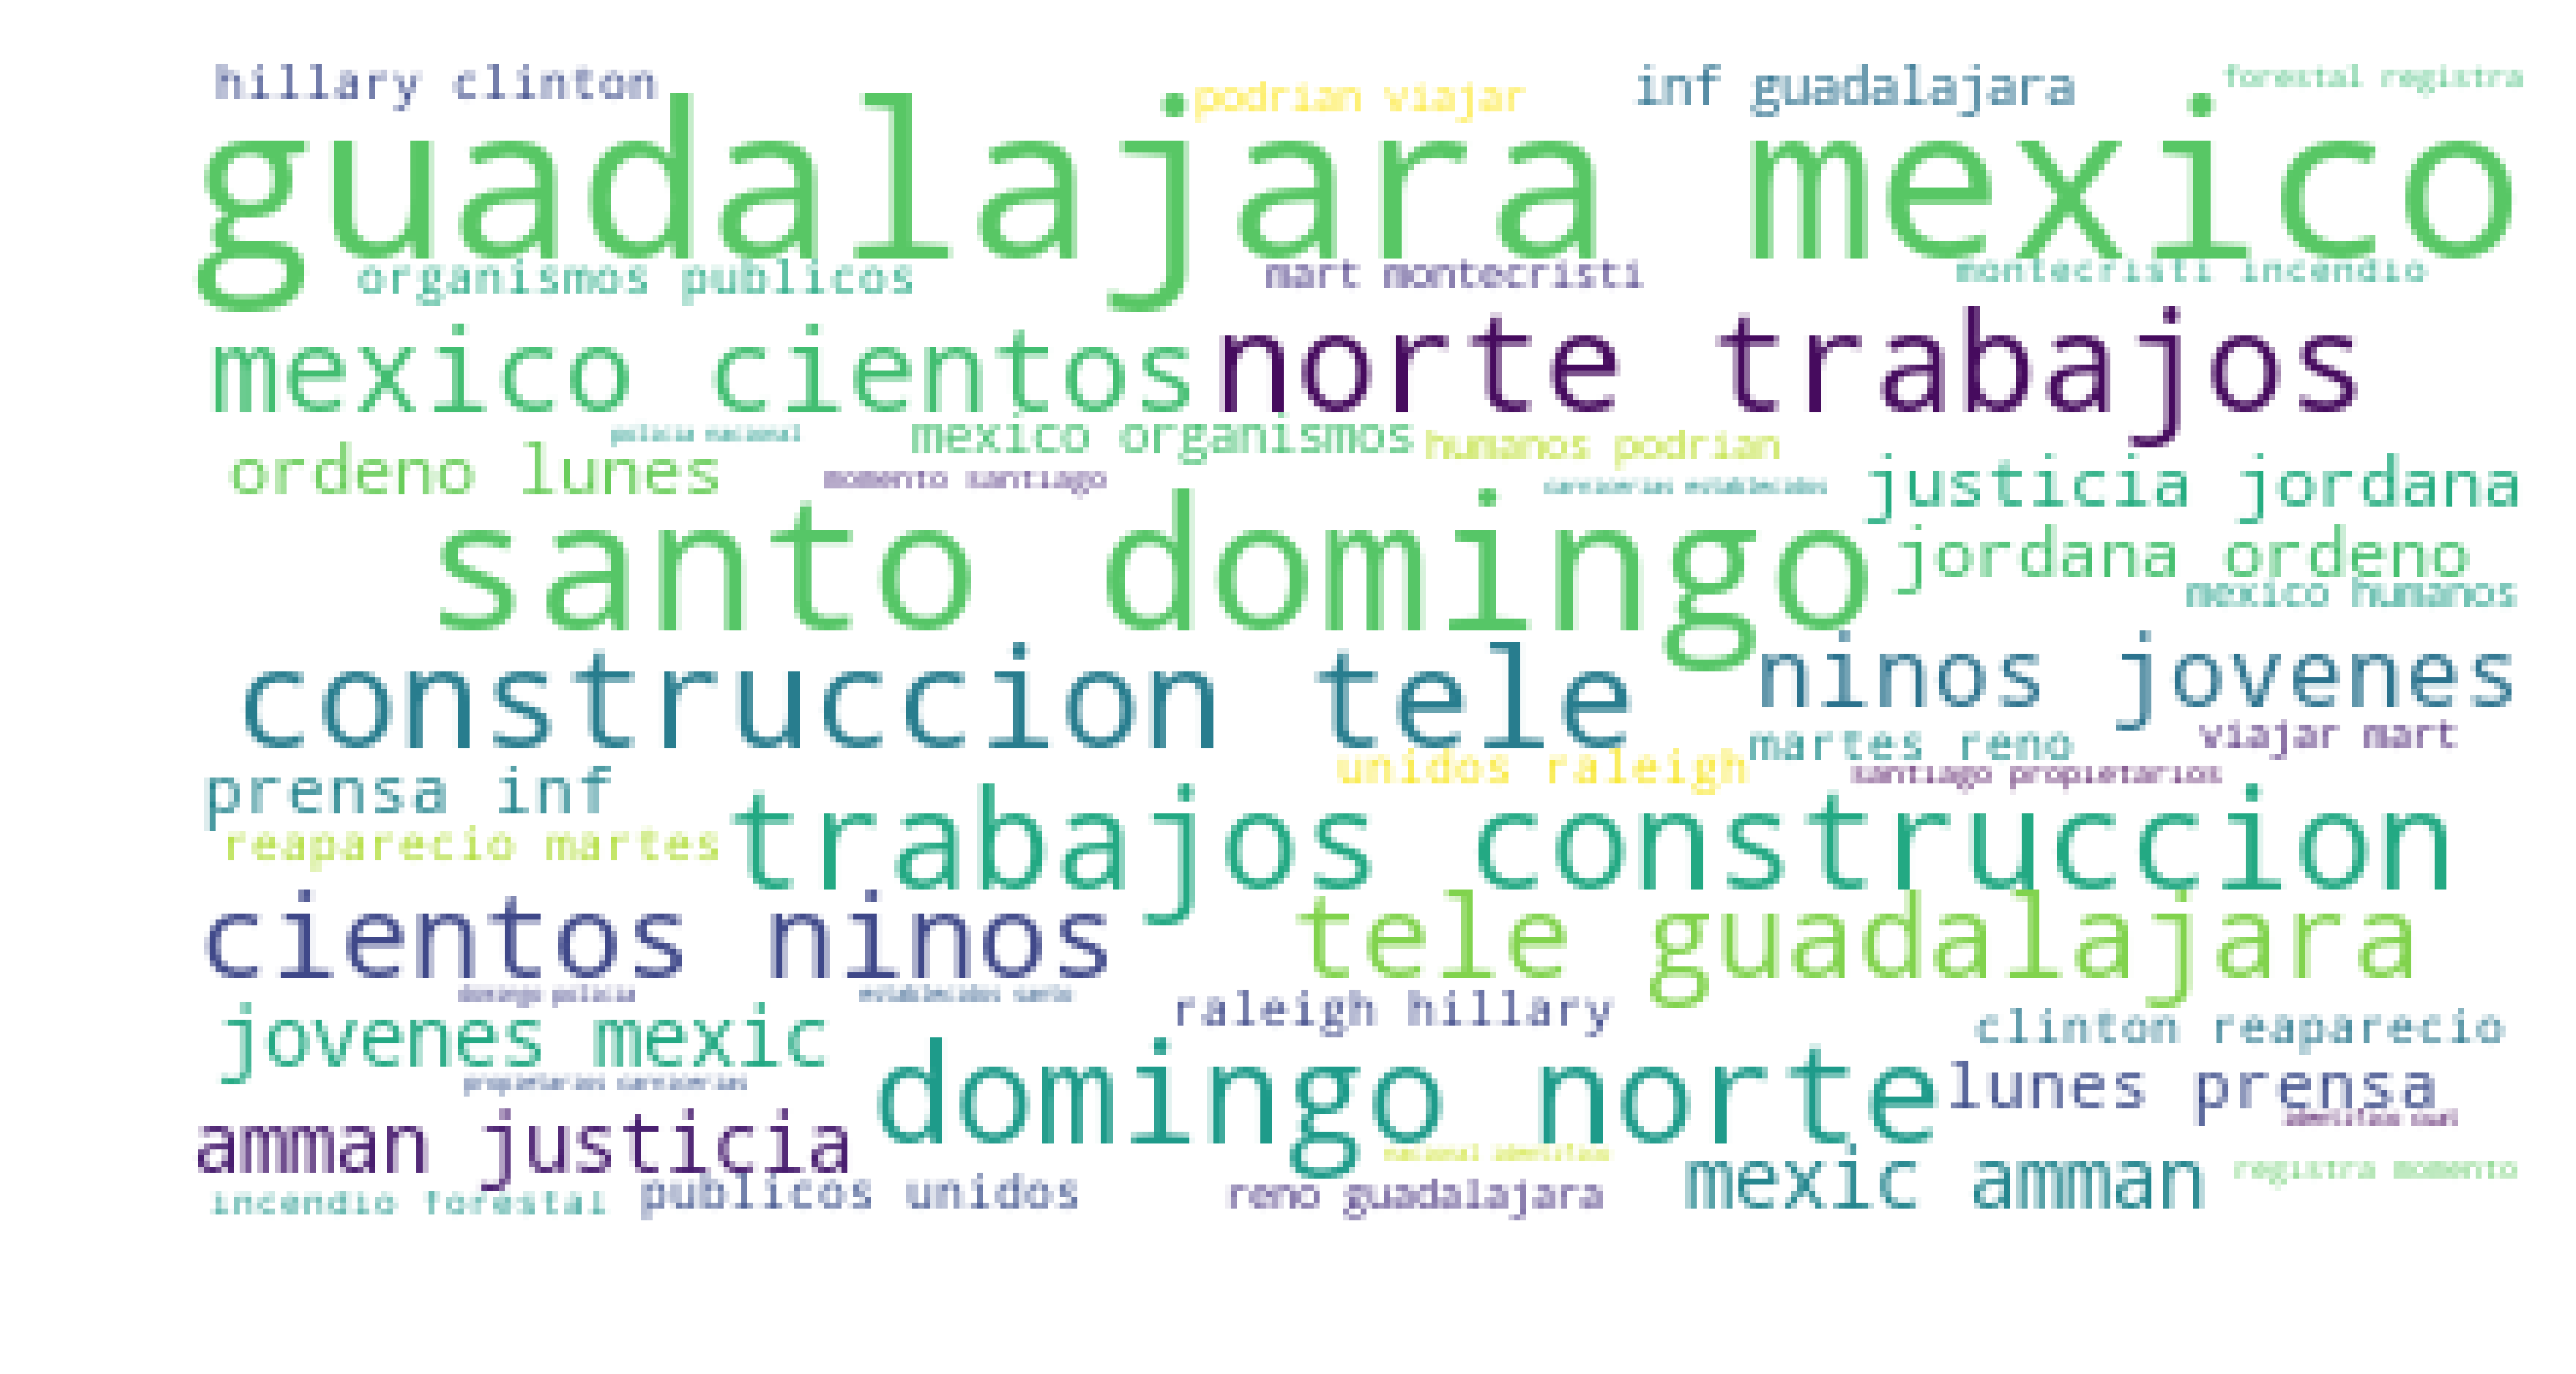

In [86]:
crear_wordcloud_mes_anio(noticias_df_completas,9,2016)